# 01-splicing_efficiency.ipynb: Quantification of spliced HBV RNAs across tissues and cell lines
Compares the proportions of spliced HBV RNAs and evaluates splice site-level splicing efficiency across liver biopsy tissues and cultured cell lines. It highlights that the splice site-level measurement may serve as a stronger biomarker than the overall proportions of HBV splicing.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

Read in Supplementary files from [Lim et al 2021](https://doi.org/10.1099/mgen.0.000492)

In [2]:
s1 = pd.read_excel("../data/processed_files/mgen-7-492-s002.xlsx", sheet_name="S1_Percent_HBV_RNA")
s1 = s1[(~s1.TCONS.isna()) & (s1.num_exons>1)].copy()
s1['HBV_genotype'] = s1.HBV_genotype.apply(lambda x: list(x)[0])
s1.rename(columns = {"Splice_variants": "Transcript ID"}, inplace=True)
sp = s1.groupby(["Library_name","Biological_materials","HBV_genotype"])["Percent_HBV_RNA"].sum().reset_index()

In [3]:
# read in SRA metadata to replace replicate IDs with Run IDs
sratbl = pd.read_csv("../data/huh7/SraRunTable.csv")
sratbl = pd.concat([sratbl[["Run",'hbv_genotype']], sp[sp.Library_name.str.contains("rep")]], axis=1)
sratbl = sratbl.drop(["Library_name","hbv_genotype"], axis=1)

sp = pd.concat([sratbl.dropna(), sp[~sp.Library_name.str.contains("rep")].rename(columns={"Library_name":"Run"})])
sp.to_csv("../results/data/Percent_HBV_RNA.csv", index=None)

In [4]:
sp.groupby("Biological_materials")["Percent_HBV_RNA"].describe()

,count,mean,std,min,25%,50%,75%,max
Biological_materials,,,,,,,,
Huh7,12.0,22.496470,5.366076,11.846812,19.944020,21.891377,28.060739,28.822891
PHH,69.0,14.542064,12.877714,0.176838,1.048511,14.185680,18.743140,63.905519
PVTT,41.0,20.791220,30.179198,0.195906,0.952231,6.896828,22.807426,97.772864
Tissue,108.0,7.996230,12.276224,0.132285,1.056800,2.792780,9.630256,83.182862
Tumor,49.0,16.007469,26.049187,0.077641,0.953740,7.002013,17.732252,97.814719


Count the number of samples by types

In [5]:
spsum = sp.value_counts("Biological_materials").reindex(["Tissue","Tumor","PVTT","PHH","Huh7"]).reset_index()
spsum

,Biological_materials,count
0,Tissue,108
1,Tumor,49
2,PVTT,41
3,PHH,69
4,Huh7,12


Compare the proportions of spliced HBV RNAs across samples (Fig 1A)

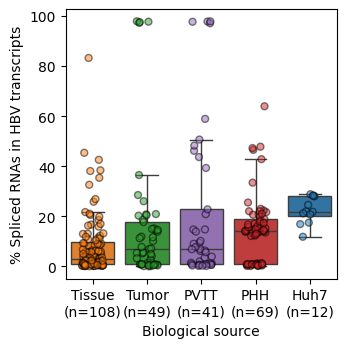

In [5]:
plt.figure(figsize=(3.5,3.5))
g = sns.boxplot(data=sp, x="Biological_materials", y="Percent_HBV_RNA", hue="Biological_materials", order=["Tissue","Tumor","PVTT","PHH","Huh7"], showfliers=False)
g = sns.stripplot(data=sp, x="Biological_materials", y="Percent_HBV_RNA", hue="Biological_materials", order=["Tissue","Tumor","PVTT","PHH","Huh7"], 
              edgecolor='black', linewidth=1, alpha=0.5, jitter=0.2)

plt.ylabel("% Spliced RNAs in HBV transcripts")
plt.xlabel("Biological source")
g.set_xticks(range(sp.value_counts("Biological_materials").shape[0]))
g.set_xticklabels(spsum.Biological_materials + "\n(n=" + spsum["count"].astype(str) + ")")
plt.savefig("../results/figures/fig1/percent_splice_variants.pdf", bbox_inches='tight')

Calculate independent t-test to compare the proportions of spliced HBV RNAs across samples

In [6]:
results = []

for i in sp["Biological_materials"].unique():
    result = ttest_ind(sp[sp["Biological_materials"]=="Tissue"]["Percent_HBV_RNA"], sp[sp["Biological_materials"]==i]["Percent_HBV_RNA"], alternative="less")
    results.append([i, result[0], result[1]])
    
results = pd.DataFrame(results)
results.columns = ["Biological_materials","t-statistic","pvalue"]
results.style.format({"pvalue": "{:.2E}"})

,Biological_materials,t-statistic,pvalue
0,Huh7,-4.036895,4.83E-05
1,Tissue,0.000000,5.00E-01
2,Tumor,-2.624081,4.78E-03
3,PHH,-3.394221,4.26E-04
4,PVTT,-3.688880,1.58E-04


In [14]:
ttest_ind(sp[sp["Biological_materials"]=="Tumor"]["Percent_HBV_RNA"], sp[sp["Biological_materials"]=="PVTT"]["Percent_HBV_RNA"], alternative="less")

TtestResult(statistic=-0.8071364729376503, pvalue=0.21088203017577495, df=88.0)

Compare the proportions of spliced HBV RNAs across genotypes (Supplementary Fig S1B)

In [5]:
sns.color_palette().as_hex()

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [6]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


Count the number of samples by genotypes

In [7]:
sp = sp[(sp.Biological_materials!="Huh7") & (sp.Biological_materials!="PHH")].copy()

spsum = sp.value_counts("HBV_genotype").reindex(["A","B","C","D"]).reset_index()
spsum

,HBV_genotype,count
0,A,1
1,B,48
2,C,145
3,D,4


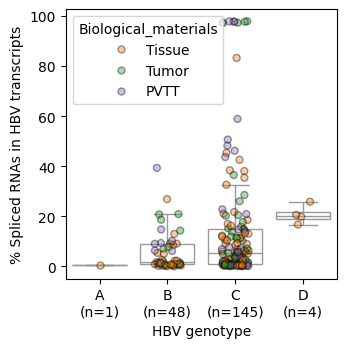

In [8]:
plt.figure(figsize=(3.5,3.5))
g = sns.boxplot(data=sp, x="HBV_genotype", y="Percent_HBV_RNA", showfliers=False, color="white", order=["A","B","C","D"])
g = sns.stripplot(data=sp, x="HBV_genotype", y="Percent_HBV_RNA", hue="Biological_materials", palette=['#ff7f0e', '#2ca02c', '#9467bd'], order=["A","B","C","D"],
              edgecolor='black', linewidth=1, alpha=0.4, jitter=0.2)
plt.ylabel("% Spliced RNAs in HBV transcripts")
plt.xlabel("HBV genotype")
g.set_xticks(range(sp.value_counts("HBV_genotype").shape[0]))
g.set_xticklabels(spsum.HBV_genotype + "\n(n=" + spsum["count"].astype(str) + ")")
plt.savefig("../results/figures/figs1/percent_splice_variants_HBV_genotype.pdf", bbox_inches='tight')

Perform independent t-tests

In [3]:
results = []

for i in sp["HBV_genotype"].unique():
    result = ttest_ind(sp[sp["HBV_genotype"]=="B"]["Percent_HBV_RNA"], sp[sp["HBV_genotype"]==i]["Percent_HBV_RNA"], alternative=less)
    results.append([i, result[0], result[1]])
    
results = pd.DataFrame(results)
results.columns = ["HBV_genotype","t-statistic","pvalue"]
results.style.format({"pvalue": "{:.2E}"})

,HBV_genotype,t-statistic,pvalue
0,A,-2.751248,8.11E-03
1,B,0.000000,1.00E+00
2,C,-2.248201,2.57E-02
3,D,-4.147771,6.15E-05


Comparing splicing efficiency (coSI) of HBV RNAs across samples

In [ ]:
! cat ../data/processed_files/*/*/stringtie.gtf > ../data/processed_files/stringtie.gtf

! gtfToGenePred ../data/processed_files/stringtie.gtf stdout \
    | genePredToBed stdin stdout | bed12ToBed6 -i stdin \
    | awk 'BEGIN{OFS="\t"} {print $4,$2,$3,$4,$5,$6}' \
    | sed 's/\./\t/' | cut -f1,3- \
    | sort -k4,4  \
    | join -1 4 -2 2 -t$'\t' -o 1.1,1.2,1.3,1.4,2.1,1.6 - \
    <(cut -f4,6 ../data/processed_files/tcons.txt | sort -k2,2) > ../data/processed_files/stringtie.bed

! for i in ../data/processed_files/*/*/intron.zeta.bed; do \
    awk -v sra=$(dirname $i) 'BEGIN{OFS="\t"} {print $1,sra,$2,$3,$4,$5,$6}' $i | sed 's|/|\t|g' | cut -f1,6- | sed 's/\t/_/'; done \
> ../data/processed_files/intron.zeta.bed

! bedtools intersect -a ../data/processed_files/stringtie.bed -b ../data/processed_files/intron.zeta.bed -wo \
    | awk 'BEGIN{FS="\t"} $NF==1 {if($3==($8+1)) {print $0 "\tdonor"} else if($2==($9-1)) {print $0 "\tacceptor"}}' > ../data/processed_files/cosi.hbv.txt

In [2]:
cosi = pd.read_csv("../data/processed_files/cosi.hbv.txt", header=None, sep="\t")
cosi[["HBV_genotype","SRA"]] = cosi[6].str.split("_", n=1, expand=True)
cosi = cosi[[0,1,2,3,4,5,13,9,10,"HBV_genotype","SRA"]]

dsra = cosi[cosi[13]=="donor"].copy()
dsra["end"] = dsra[2] + 2
dsra = dsra[[0,2,"end",3,4,5,13,9,10,"HBV_genotype","SRA"]]
dsra.columns = ["chrom","start","end","name","name2","strand","Splice site","coSI 3'","coSI 5'","HBV_genotype","SRA"]

asra = cosi[cosi[13]=="acceptor"].copy()
asra["start"] = asra[1] - 2
asra = asra[[0,"start",1,3,4,5,13,9,10,"HBV_genotype","SRA"]]
asra.columns = ["chrom","start","end","name","name2","strand","Splice site","coSI 3'","coSI 5'","HBV_genotype","SRA"]

cosi = pd.concat([dsra, asra])


tcons = pd.read_csv("../data/processed_files/tcons.txt", header=None, sep="\t")
tcons = tcons[[0,1,3,4,5]]
tcons.columns = ["SRA","Biological_materials","name2","HBV_genotype","name"]

id_mapping = pd.read_csv("../data/processed_files/map.txt", header=None, sep="\t")
id_mapping.columns = ["Transcript ID","name2"]

tcons = pd.merge(tcons, id_mapping, how="left")
cosi = pd.merge(cosi, tcons)
nanid = cosi[cosi["Transcript ID"].isna()].copy()
nanid["Transcript ID"] = nanid["name2"]
cosi = pd.concat([cosi[~cosi["Transcript ID"].isna()].copy(), nanid])
cosi = cosi[~cosi["Transcript ID"].str.contains("TCONS_00000075|TCONS_00000076|TCONS_00000087|TCONS_00000088")]

dsra = cosi[cosi["Splice site"]=="donor"].drop("coSI 3'", axis=1).drop_duplicates().copy()
asra = cosi[cosi["Splice site"]=="acceptor"].drop("coSI 5'", axis=1).drop_duplicates().copy()
cosi = pd.merge(dsra,asra, on=['chrom','name', 'name2', 'strand', 'HBV_genotype', 'SRA', 'Biological_materials', 'Transcript ID'])

dsra = dsra.rename(columns={"coSI 5'":"Splicing efficiency"})
dsra["coSI"] = r"$\theta_5$"
asra = asra.rename(columns={"coSI 3'":"Splicing efficiency"})
asra["coSI"] = r"$\theta_3$"
cosi_long = pd.concat([dsra, asra])

cosi.to_pickle("../data/processed_files/cosi.pkl.gz")
cosi_long.to_pickle("../data/processed_files/cosi_long.pkl.gz")

In [8]:
cosi_long.sort_values("Splicing efficiency")

,chrom,start,end,name,name2,strand,Splice site,Splicing efficiency,HBV_genotype,SRA,Biological_materials,Transcript ID,coSI
2524,D3_SRR5992894,1827,1829,D3_SRR5992894.2.4,TCONS_00000001,+,donor,0.00094,D3,SRR5992894,PHH,pSP9,$\theta_5$
2520,D3_SRR5992894,1827,1829,D3_SRR5992894.2.3,TCONS_00000047,+,donor,0.00094,D3,SRR5992894,PHH,pSP10,$\theta_5$
1769,D3_SRR5145396,1827,1829,D3_SRR5145396.1.3,TCONS_00000047,+,donor,0.00102,D3,SRR5145396,PHH,pSP10,$\theta_5$
1773,D3_SRR5145396,1827,1829,D3_SRR5145396.1.4,TCONS_00000001,+,donor,0.00102,D3,SRR5145396,PHH,pSP9,$\theta_5$
5242,D3_SRR5992882,2453,2455,D3_SRR5992882.1.7,TCONS_00000065,+,acceptor,0.00105,D3,SRR5992882,PHH,93050_ccs,$\theta_3$
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2918,D3_SRR6872346,634,636,D3_SRR6872346.2.1,TCONS_00000012,+,donor,NaN,D3,SRR6872346,PHH,SP1,$\theta_5$
3117,D3_SRR9592409,658,660,D3_SRR9592409.1.1,TCONS_00000002,+,donor,NaN,D3,SRR9592409,PHH,SP6,$\theta_5$
1083,C2_SRR3140465,274,276,C2_SRR3140465.3.3,TCONS_00000083,+,donor,NaN,C2,SRR3140465,PVTT,TCONS_00000083,$\theta_5$
1085,C2_SRR3140466,274,276,C2_SRR3140466.1.2,TCONS_00000083,+,donor,NaN,C2,SRR3140466,PVTT,TCONS_00000083,$\theta_5$


Count the number of samples by types

In [3]:
cosisum = cosi.drop_duplicates("SRA").value_counts("Biological_materials").reindex(["Tissue","Tumor","PVTT","PHH","Huh7"]).reset_index()
cosisum

,Biological_materials,count
0,Tissue,53
1,Tumor,21
2,PVTT,13
3,PHH,49
4,Huh7,12


Compare the splicing efficiency of HBV splice sites across samples (Fig 1B)

In [4]:
sns.color_palette("Pastel2").as_hex()

['#b3e2cd',
 '#fdcdac',
 '#cbd5e8',
 '#f4cae4',
 '#e6f5c9',
 '#fff2ae',
 '#f1e2cc',
 '#cccccc']

In [5]:
print(sns.color_palette("Pastel2").as_hex())

['#b3e2cd', '#fdcdac', '#cbd5e8', '#f4cae4', '#e6f5c9', '#fff2ae', '#f1e2cc', '#cccccc']


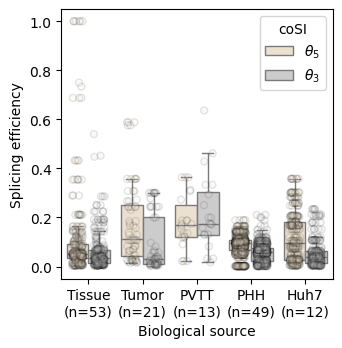

In [6]:
plt.figure(figsize=(3.5,3.5))
g = sns.boxplot(data=cosi_long, x="Biological_materials", y="Splicing efficiency", hue="coSI", order=["Tissue","Tumor","PVTT","PHH","Huh7"], showfliers=False, palette=['#f1e2cc', '#cccccc'])
g = sns.stripplot(data=cosi_long, x="Biological_materials", y="Splicing efficiency", hue="coSI", order=["Tissue","Tumor","PVTT","PHH","Huh7"], 
                  edgecolor='black', linewidth=1, alpha=0.1, jitter=0.2, dodge=True, legend=False, palette=['#f1e2cc', '#cccccc'])

plt.ylabel(r"Splicing efficiency")
plt.xlabel("Biological source")
g.set_xticks(range(cosi_long.drop_duplicates("SRA").value_counts("Biological_materials").shape[0]))
g.set_xticklabels(cosisum.Biological_materials + "\n(n=" + cosisum["count"].astype(str) + ")")
plt.savefig("../results/figures/fig1/cosi_splice_variants.pdf", bbox_inches='tight')

Get the top 10 most common spliced HBV RNAs and plot Supplementary Fig S1

In [7]:
tcounts = cosi.drop_duplicates(["Transcript ID", "SRA"]).value_counts("Transcript ID").reset_index()
tcounts.head(10)["Transcript ID"].tolist()

['SP1', 'SP14', 'SP7', 'pSP12', 'SP9', 'SP6', 'SP13', 'SP18', 'SP11', 'pSP9']

In [8]:
tcounts.shape

(77, 2)

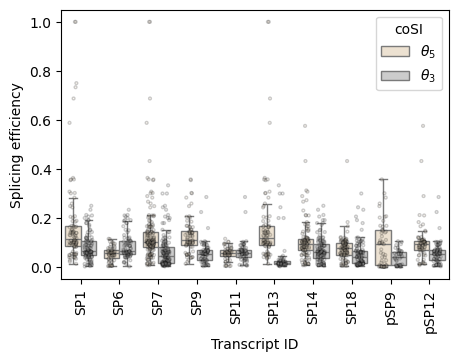

In [7]:
plt.figure(figsize=(5,3.5))

g = sns.boxplot(data=cosi_long,
            x="Transcript ID", y="Splicing efficiency", hue="coSI", 
            showfliers=False, order=['SP1', 'SP6', 'SP7', 'SP9', 'SP11', 'SP13', 'SP14', 'SP18', 'pSP9', 'pSP12'], 
            palette=['#f1e2cc', '#cccccc'])
g = sns.stripplot(data=cosi_long, x="Transcript ID", y="Splicing efficiency", hue="coSI", 
                  order=['SP1', 'SP6', 'SP7', 'SP9', 'SP11', 'SP13', 'SP14', 'SP18', 'pSP9', 'pSP12'], 
                  edgecolor='black', s=2, linewidth=1, alpha=0.2, jitter=0.2, dodge=True, legend=False, palette=['#f1e2cc', '#cccccc'])

plt.xticks(rotation=90)
plt.savefig("../results/figures/figs1/cosi_splice_variants-sm.pdf", bbox_inches='tight')

In [24]:
cosi_long[cosi_long["Transcript ID"].str.contains("pSP")].shape, cosi_long[cosi_long["Transcript ID"].str.contains("TCONS")].shape

((490, 13), (413, 13))

In [3]:
cosi = pd.read_pickle("../data/processed_files/cosi.pkl.gz")
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")
tcounts = cosi.drop_duplicates(["Transcript ID", "SRA"]).value_counts("Transcript ID").reset_index()

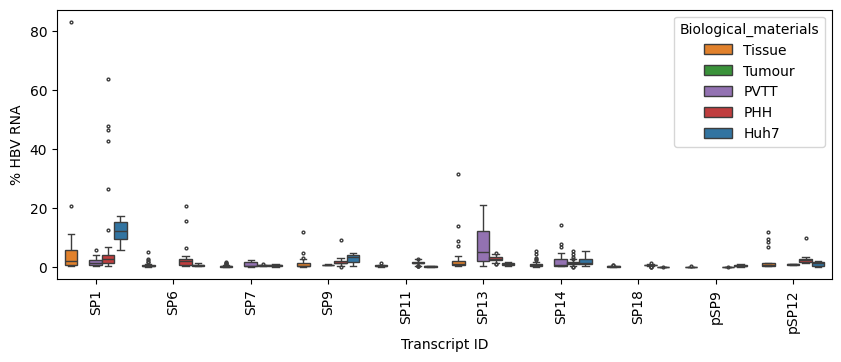

In [8]:
plt.figure(figsize=(10, 3.5))
g = sns.boxplot(data=s1,
            x="Transcript ID", y="Percent_HBV_RNA", fliersize=2,
            hue="Biological_materials", hue_order=["Tissue","Tumour","PVTT","PHH","Huh7"],
            palette=['#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#1f77b4'],
            order=['SP1', 'SP6', 'SP7', 'SP9', 'SP11', 'SP13', 'SP14', 'SP18', 'pSP9', 'pSP12'])
plt.ylabel("% HBV RNA")
plt.xticks(rotation=90)
plt.savefig("../results/figures/figs1/percent_rna-sm.pdf", bbox_inches='tight')

In [5]:
s1.groupby(["Biological_materials","Transcript ID"])["Percent_HBV_RNA"].mean().reset_index().sort_values("Percent_HBV_RNA", ascending=False)

,Biological_materials,Transcript ID,Percent_HBV_RNA
2,Huh7,SP1,12.070794
36,PVTT,SP13,7.850587
72,Tumor,SP13,7.369364
22,PHH,SP1,6.104586
56,Tissue,SP1,4.634285
...,...,...,...
20,PHH,81196_ccs,0.026473
19,PHH,27415_ccs,0.024997
21,PHH,93050_ccs,0.023794
18,PHH,125795_ccs,0.022178


In [5]:
s1.groupby("Biological_materials").mean("Total_splice_variants")

,Library_size,num_exons,Percent_HBV_RNA,Total_splice_variants
Biological_materials,,,,
Huh7,1.801284e+07,2.569231,1.384398,12.876923
PHH,3.295579e+07,2.424870,1.732992,11.597582
PVTT,1.695587e+07,2.113636,9.686818,2.181818
Tissue,2.427406e+07,2.302905,1.791686,7.074689
Tumor,2.419083e+07,2.200000,5.810118,3.533333


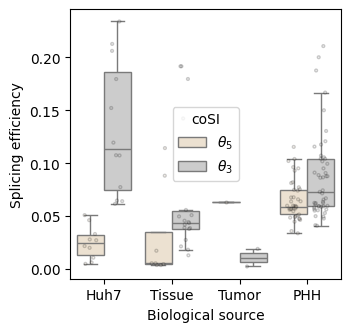

In [6]:
plt.figure(figsize=(3.5,3.5))

g = sns.boxplot(data=cosi_long[cosi_long["Transcript ID"] == "SP6"], x="Biological_materials", y="Splicing efficiency", hue="coSI", 
                showfliers=False, palette=['#f1e2cc', '#cccccc'])
g = sns.stripplot(data=cosi_long[cosi_long["Transcript ID"] == "SP6"], x="Biological_materials", y="Splicing efficiency", hue="coSI", 
                  edgecolor='black', s=2, linewidth=1, alpha=0.2, jitter=0.2, dodge=True, legend=False, palette=['#f1e2cc', '#cccccc'])
plt.xlabel("Biological source")

plt.savefig("../results/figures/figs1/sp6-sm.pdf", bbox_inches='tight')

Create annotation for lollipop plot in Fig 1C

In [ ]:
! join -t$'\t' \
    <(gtfToGenePred ../data/processed_files/combined.gtf stdout | sort -k1,1) \
    <(echo -e "SP1\nSP6\nSP7\nSP9\nSP11\nSP13\nSP14\nSP18\npSP9\npSP12" | sort) \
    | genePredToGtf file stdin ../data/processed_files/track.gtf

! cat <(awk '$4!=1 {print $4}' ../data/processed_files/track.gtf) <(awk '$5!=3246 {print $5}' ../data/processed_files/track.gtf) | sort -u \
    | join -t$'\t' - \
    <(sed '1d' ../data/processed_files/lol.txt | sort -k1,1) \
    | sed '1i pos\tlabel\tss' > ../data/processed_files/track.lol.txt

In [1]:
import pandas as pd

cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")

c3 = cosi_long[cosi_long.coSI=='$\\theta_3$'].copy()
c3["pos"] = c3["end"]+1

c5 = cosi_long[cosi_long.coSI=='$\\theta_5$'].copy()
c5["pos"] = c5["start"]

se = pd.concat([c5,c3]).groupby("pos")["Splicing efficiency"].median().reset_index()
se.columns = ["pos","coSI"]

lol = pd.read_csv("../data/processed_files/track.lol.txt", sep="\t")

lol = pd.merge(lol,se)
lol.to_csv("../data/processed_files/track.lol.txt", sep="\t", index=None)

In [ ]:
! Rscript ../scripts/track.r

Calculcate independent t-tests for comparing splicing efficiency across samples for Fig 1B

In [11]:
results = []

for i in cosi["Biological_materials"].unique():
    result = ttest_ind(cosi[cosi["Biological_materials"]=="Tissue"]["coSI 5'"].dropna(), cosi[cosi["Biological_materials"]==i]["coSI 5'"].dropna(), alternative="less")
    results.append([i, result[0], result[1]])
    
results = pd.DataFrame(results)
results.columns = ["Biological_materials","t-statistic","pvalue"]
results.style.format({"pvalue": "{:.2E}"})

,Biological_materials,t-statistic,pvalue
0,Huh7,-2.005513,2.26E-02
1,Tissue,0.000000,5.00E-01
2,Tumor,-4.244280,1.41E-05
3,PVTT,-2.301029,1.10E-02
4,PHH,0.990948,8.39E-01


In [12]:
results = []

for i in cosi["Biological_materials"].unique():
    result = ttest_ind(cosi[cosi["Biological_materials"]=="Tissue"]["coSI 3'"].dropna(), cosi[cosi["Biological_materials"]==i]["coSI 3'"].dropna(), alternative="less")
    results.append([i, result[0], result[1]])
    
results = pd.DataFrame(results)
results.columns = ["Biological_materials","t-statistic","pvalue"]
results.style.format({"pvalue": "{:.2E}"})

,Biological_materials,t-statistic,pvalue
0,Huh7,2.545496,9.94E-01
1,Tissue,0.000000,5.00E-01
2,Tumor,-5.268017,1.20E-07
3,PVTT,-8.881673,2.47E-17
4,PHH,1.311271,9.05E-01


In [10]:
ttest_ind(cosi[cosi["Biological_materials"]=="Tumor"]["coSI 5'"].dropna(), cosi[cosi["Biological_materials"]=="PVTT"]["coSI 5'"].dropna(), alternative="less")

TtestResult(statistic=0.30896047870786003, pvalue=0.6208376013584471, df=66.0)

In [9]:
ttest_ind(cosi[cosi["Biological_materials"]=="Tumor"]["coSI 3'"].dropna(), cosi[cosi["Biological_materials"]=="PVTT"]["coSI 3'"].dropna(), alternative="less")

TtestResult(statistic=-2.9298181769866365, pvalue=0.002297156702884084, df=69.0)

Prepare data files for results

In [1]:
import pandas as pd

s1 = pd.read_excel("../data/processed_files/mgen-7-492-s002.xlsx", sheet_name="S1_Percent_HBV_RNA")
s1 = s1[(~s1.TCONS.isna()) & (s1.num_exons>1)].copy()
s1['HBV_genotype'] = s1.HBV_genotype.apply(lambda x: list(x)[0])
sp = s1.groupby(["Library_name","Biological_materials","HBV_genotype"])["Percent_HBV_RNA"].sum().reset_index()

# read in SRA metadata to replace replicate IDs with Run IDs
sratbl = pd.read_csv("../data/huh7/SraRunTable.csv")
sratbl = pd.concat([sratbl[["Run",'hbv_genotype']], sp[sp.Library_name.str.contains("rep")]], axis=1)

In [2]:
cosi_long = pd.read_pickle("../data/processed_files/cosi_long.pkl.gz")

huh7 = pd.merge(cosi_long, sratbl[["Run","Library_name"]].rename(columns={"Library_name":"SRA"}))
huh7 = huh7.drop("SRA", axis=1)#.rename(columns={"Run":"Library_name"})

cosi_long = cosi_long[~cosi_long.SRA.str.contains("rep")].rename(columns={"SRA":"Run"})
cosi_long = pd.concat([huh7, cosi_long])
cosi_long["HBV_genotype"] = cosi_long.HBV_genotype.apply(lambda x: list(x)).str[0]

cosi_long.to_csv("../results/data/coSI.csv", index=None)